In [2]:
from dask_jobqueue import SLURMCluster 
from dask.distributed import Client 
  
cluster = SLURMCluster(cores=28,name='make_profiles',walltime='00:30:00',job_extra=['--constraint=HSW24','--exclusive','--nodes=1'],memory='120GB',interface='ib0') 
cluster.scale(136)
cluster

/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/distributed/bokeh/core.py:74: UserWarning: 
Failed to start diagnostics server on port 8787. [Errno 13] Permission denied
  warnings.warn("\n" + msg)


In [3]:
from dask.distributed import Client
client = Client(cluster)
client

<Client: scheduler='tcp://172.30.100.1:42974' processes=0 cores=0>

In [4]:
import sys
import numpy as np
import numpy.ma as ma
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean
import glob

%matplotlib inline


/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/xarray/core/merge.py:16: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [5]:
#params

plot_eke_annual=True


In [6]:
config='EU36'
case='MPC001'
freq='1d'
year='2010'

datadir='/scratch/cnt0024/hmg2840/colombo/'+str(config)+'/'+str(config)+'-'+str(case)+'-S/'+str(freq)+'/'+str(year)+'/'
#!ls $datadir
gridfile='/scratch/cnt0024/hmg2840/colombo/EU36/EU36-I/coordinates_EU36.nc'
maskfile='/scratch/cnt0024/hmg2840/colombo/EU36/EU36-I/EU36.L75_mesh_mask.nc'

In [7]:
dsgrid=xr.open_dataset(gridfile)
dsmask=xr.open_dataset(maskfile)

In [8]:
def compute_EKE(u,v,u2mean,v2mean):
    ua=0.5*((u2mean-u*u)+(u2mean.shift(x=-1)-u.shift(x=-1)*u.shift(x=-1)))
    va=0.5*((v2mean-v*v)+(v2mean.shift(y=-1)-v.shift(y=-1)*v.shift(y=-1)))
    uat=ua.rename({'depthu':'deptht'})
    vat=va.rename({'depthv':'deptht'})
    eke=0.5*(uat+vat)
    return eke


In [9]:
month_name={1:'January',2:'February',3:'March',4:'April',5:'May',6:'June',7:'July',8:'August',9:'September',10:'October',11:'November',12:'December'}
def plot_monthly(var,mask,vmin,vmax,cmap,title,figfile):
    fig, axes = plt.subplots(3,4,figsize=(30,20))
    axes = axes.ravel()
    for m in np.arange(1,13):
        if m < 10:
            month='0'+str(m)
        else:
            month=str(m)
        if m in [1,3,5,7,8,10,12]:
            dayf='31'
        elif m == 2:
            dayf='28'
        else:
            dayf='30'
        ax=axes[m-1]
        var.sel(time_counter=slice('2010-'+month+'-01','2010-'+month+'-'+dayf)).mean(dim='time_counter').where(mask==1).plot(cmap=cmap,ax=ax,vmin=vmin,vmax=vmax,add_labels=True)
        ax.set_title(month_name[m])
    fig.suptitle('Monthly mean of '+str(title))
    plt.savefig(config+'-'+case+'y'+str(year)+'.1m_'+figfile+'.png')

In [10]:
month_name={1:'January',2:'February',3:'March',4:'April',5:'May',6:'June',7:'July',8:'August',9:'September',10:'October',11:'November',12:'December'}
def plot_one_month(var,mask,vmin,vmax,cmap,title,figfile,m):
    fig, ax = plt.subplots(1,1,figsize=(10,15))
    if m < 10:
        month='0'+str(m)
    else:
        month=str(m)
    if m in [1,3,5,7,8,10,12]:
        dayf='31'
    elif m == 2:
        dayf='28'
    else:
        dayf='30'
    var.sel(time_counter=slice('2010-'+month+'-01','2010-'+month+'-'+dayf)).mean(dim='time_counter').where(mask==1).plot(cmap=cmap,ax=ax,vmin=vmin,vmax=vmax,add_labels=True)
    ax.set_title(month_name[m])
    fig.suptitle('Monthly mean of '+str(title))
    plt.savefig(config+'-'+case+'y'+str(year)+'m'+str(month)+'_'+figfile+'.png')

In [11]:
def plot_annual(var,mask,vmin,vmax,cmap,title,figfile):
    fig, ax = plt.subplots(1,1,figsize=(10,15))
    var.mean(dim='time_counter').where(mask==1).plot(cmap=cmap,ax=ax,vmin=vmin,vmax=vmax,add_labels=True)
    fig.suptitle('Annual mean of '+str(title))
    plt.savefig(config+'-'+case+'_y'+str(year)+'.1y_'+figfile+'.png')    

In [12]:
filesU=sorted(glob.glob(datadir+'/'+str(config)+'-'+str(case)+'_y'+str(year)+'m??d??.'+str(freq)+'_gridU.nc'))
filesV=sorted(glob.glob(datadir+'/'+str(config)+'-'+str(case)+'_y'+str(year)+'m??d??.'+str(freq)+'_gridV.nc'))
dsU=xr.open_mfdataset(filesU, chunks={'x':700,'y':1000,'time_counter':1,'depthu':1})
dsV=xr.open_mfdataset(filesV, chunks={'x':700,'y':1000,'time_counter':1,'depthv':1})
u=dsU.vozocrtx
v=dsV.vomecrty
mask=dsmask.tmask[0]
u2=u*u
v2=v*v
u2mean=u2.mean(dim='time_counter')
v2mean=v2.mean(dim='time_counter')
eke=compute_EKE(u,v,u2mean,v2mean)


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


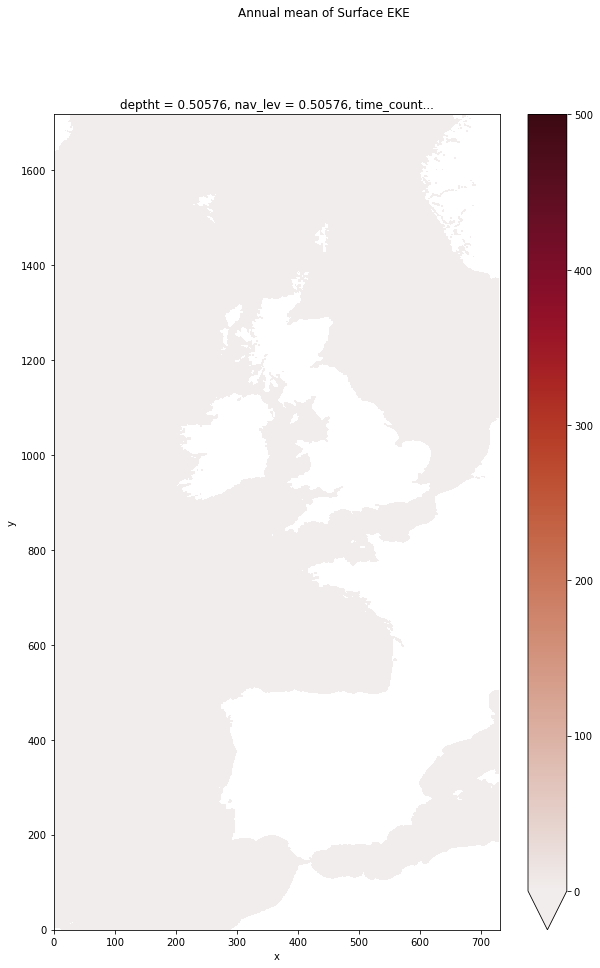

In [39]:
plot_annual(10000*eke[0],mask[0],0,500,'cmo.amp','Surface EKE','eke_surf')
    

distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
JobQueueCluster.scale_up was called with a number of workers lower that what is already running or pending
JobQueueCluster.scale_up was called with a number of workers lower that what is already running or pending
JobQueueCluster.scale_up was called with a number of workers lower that what is already running or pending
JobQueueCluster.scale_up was called with a number of workers lower that what is already running or pending
JobQueueCluster.scale_up was called with a number of workers lower that what is already running or pending
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
JobQueueCluster.scale_up was called with a number of workers lower that what is already running or pending
JobQueueCluster.scale_up was called with a num

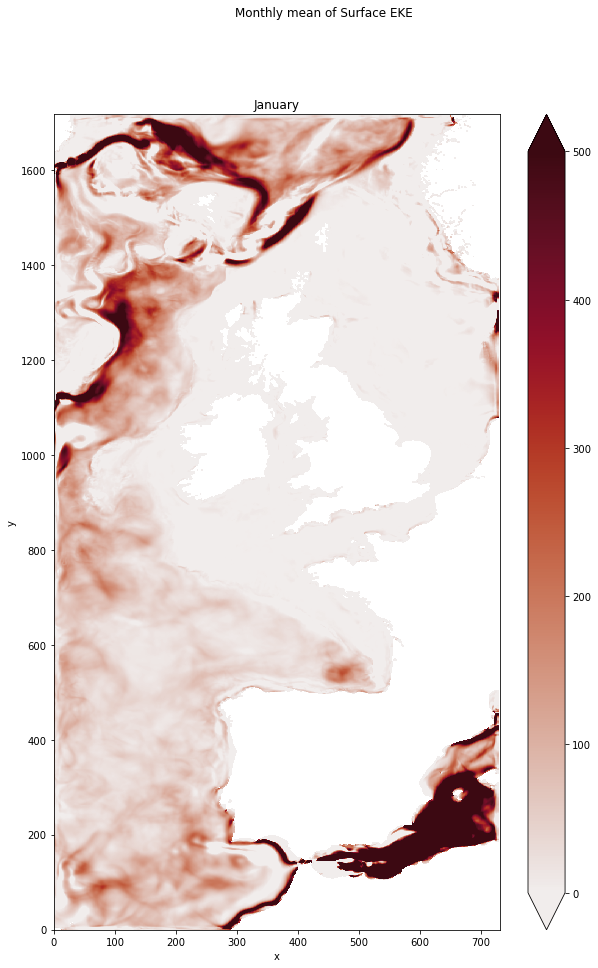

In [20]:
#plot_one_month(10000*eke[0],mask[0],0,500,'cmo.amp','Surface EKE','eke_surf',1)

distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


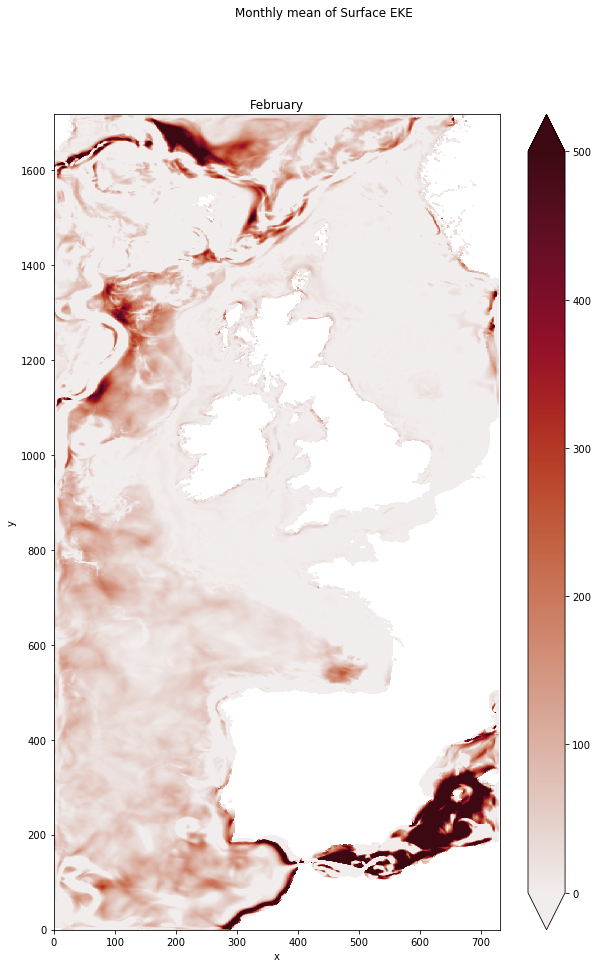

In [40]:
plot_one_month(10000*eke[0],mask[0],0,500,'cmo.amp','Surface EKE','eke_surf',2)

distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


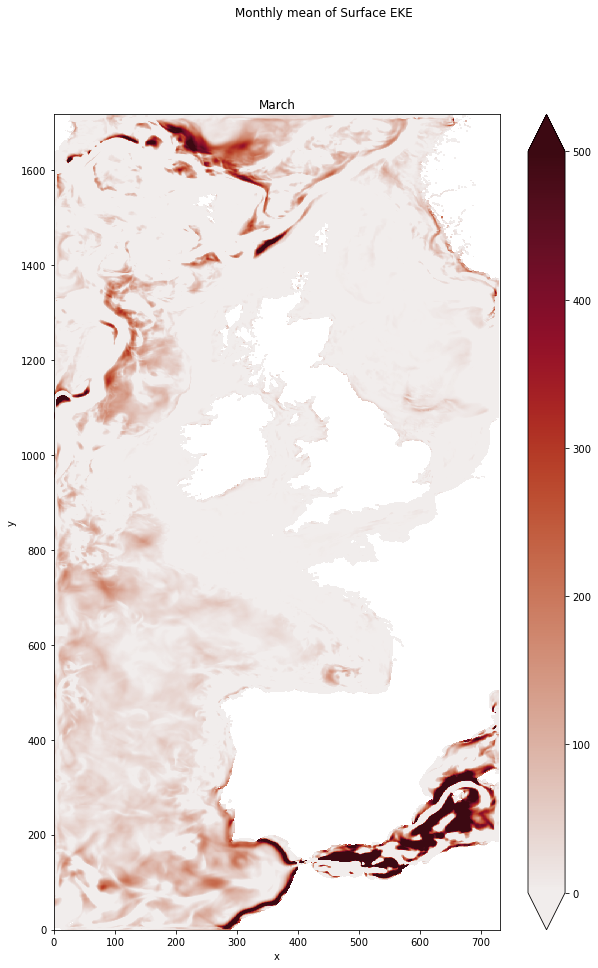

In [41]:
plot_one_month(10000*eke[0],mask[0],0,500,'cmo.amp','Surface EKE','eke_surf',3)

distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


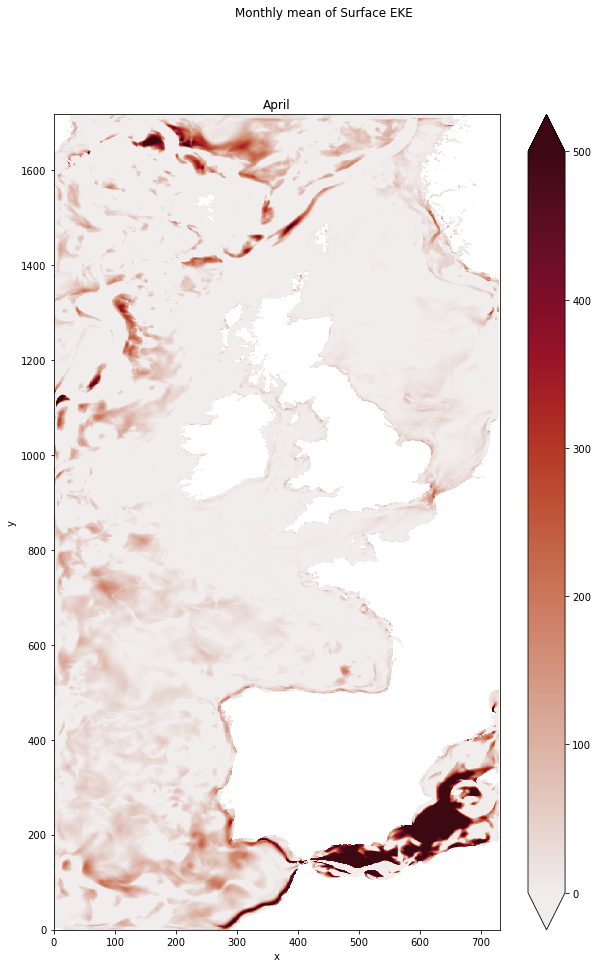

In [42]:
plot_one_month(10000*eke[0],mask[0],0,500,'cmo.amp','Surface EKE','eke_surf',4)

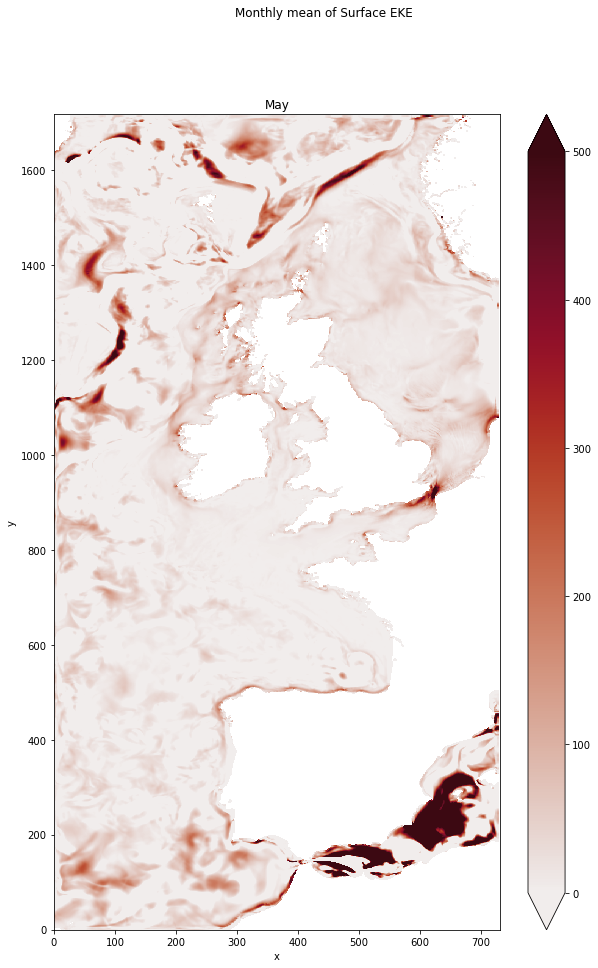

In [13]:
plot_one_month(10000*eke[0],mask[0],0,500,'cmo.amp','Surface EKE','eke_surf',5)

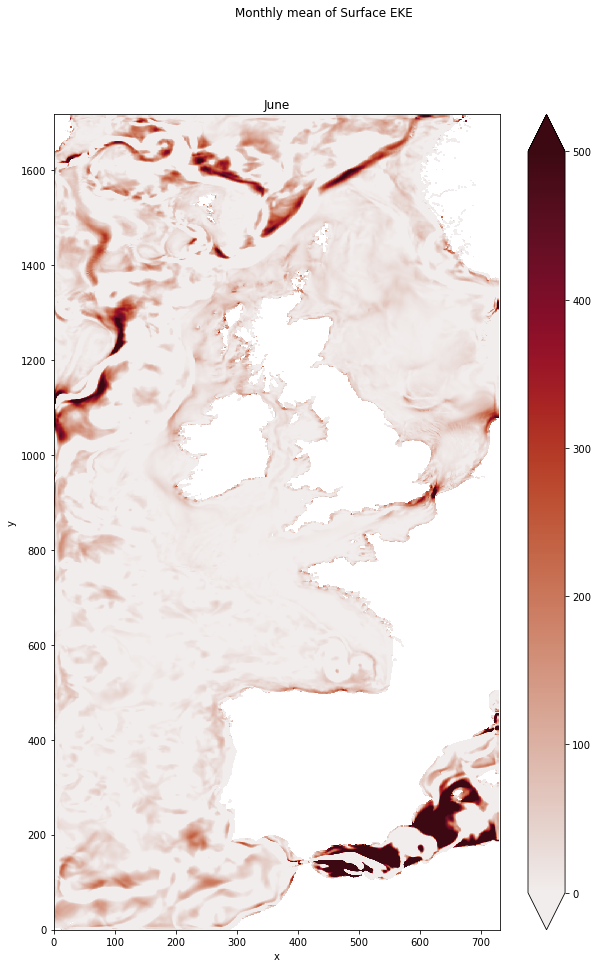

In [14]:
plot_one_month(10000*eke[0],mask[0],0,500,'cmo.amp','Surface EKE','eke_surf',6)

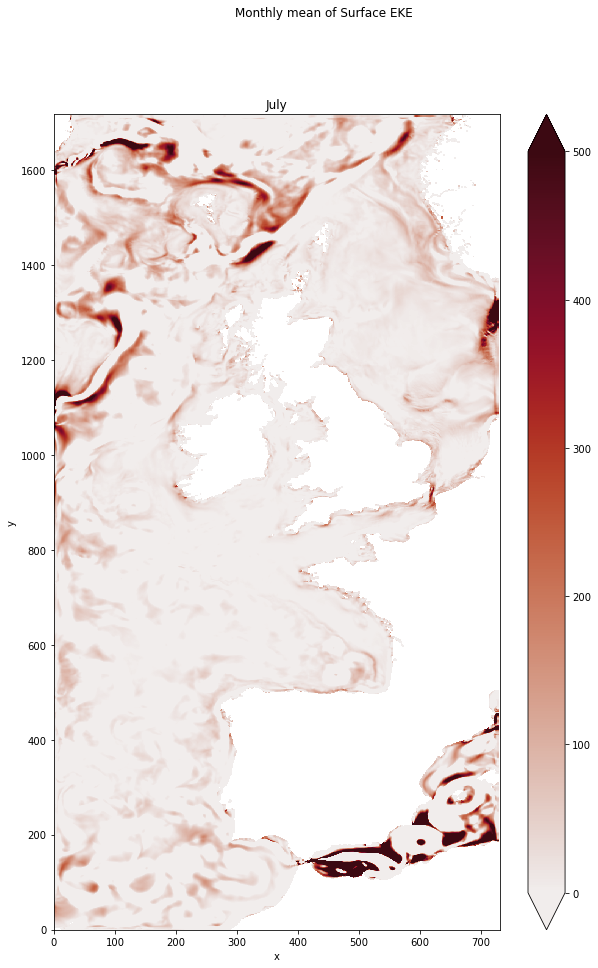

In [15]:
plot_one_month(10000*eke[0],mask[0],0,500,'cmo.amp','Surface EKE','eke_surf',7)

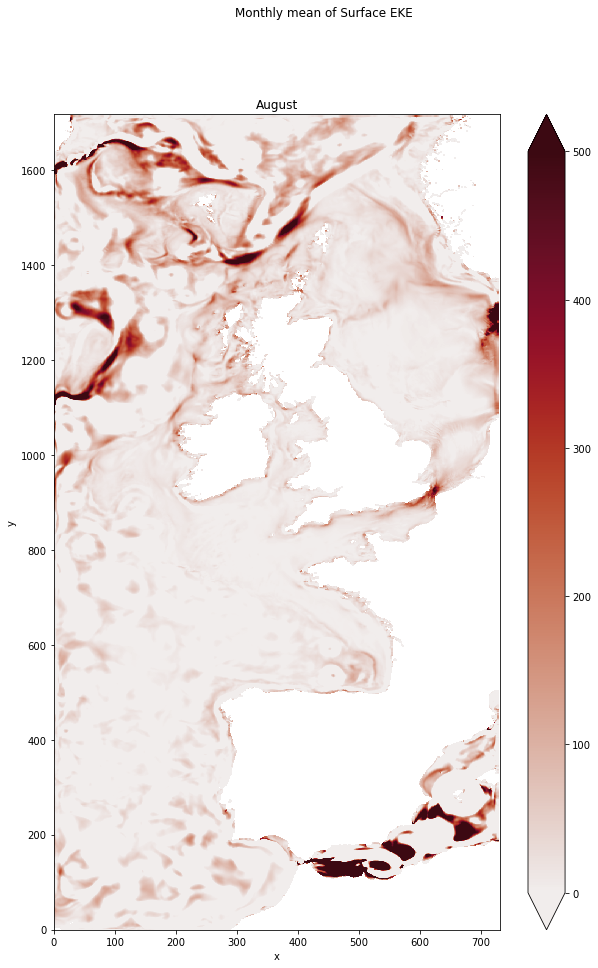

In [16]:
plot_one_month(10000*eke[0],mask[0],0,500,'cmo.amp','Surface EKE','eke_surf',8)

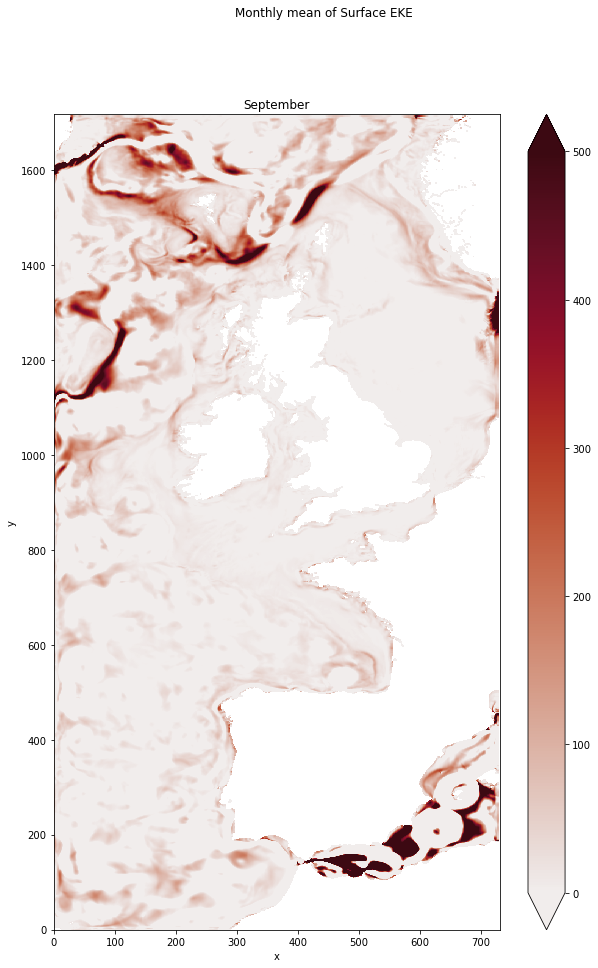

In [17]:
plot_one_month(10000*eke[0],mask[0],0,500,'cmo.amp','Surface EKE','eke_surf',9)

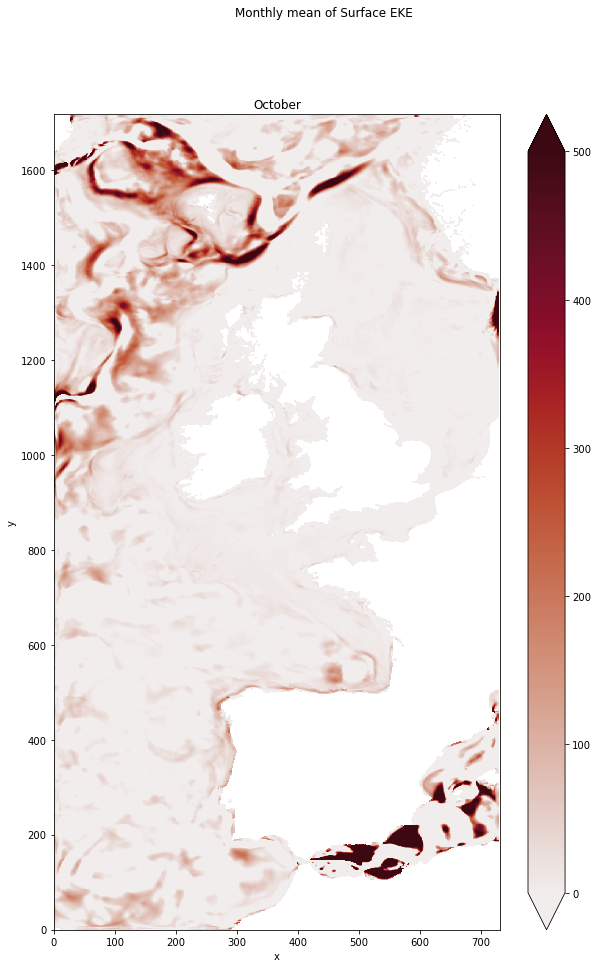

In [18]:
plot_one_month(10000*eke[0],mask[0],0,500,'cmo.amp','Surface EKE','eke_surf',10)

distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


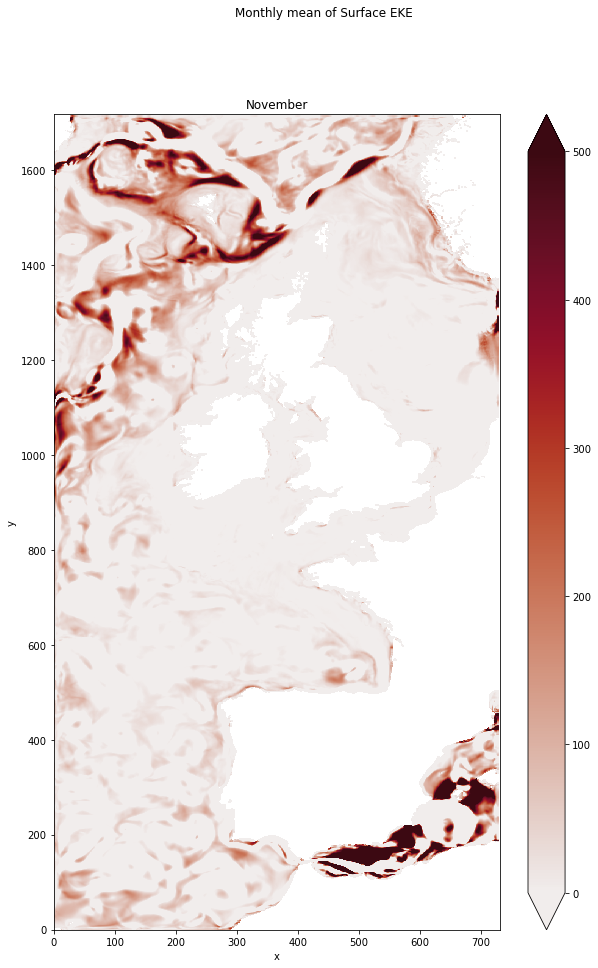

In [19]:
plot_one_month(10000*eke[0],mask[0],0,500,'cmo.amp','Surface EKE','eke_surf',11)

distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


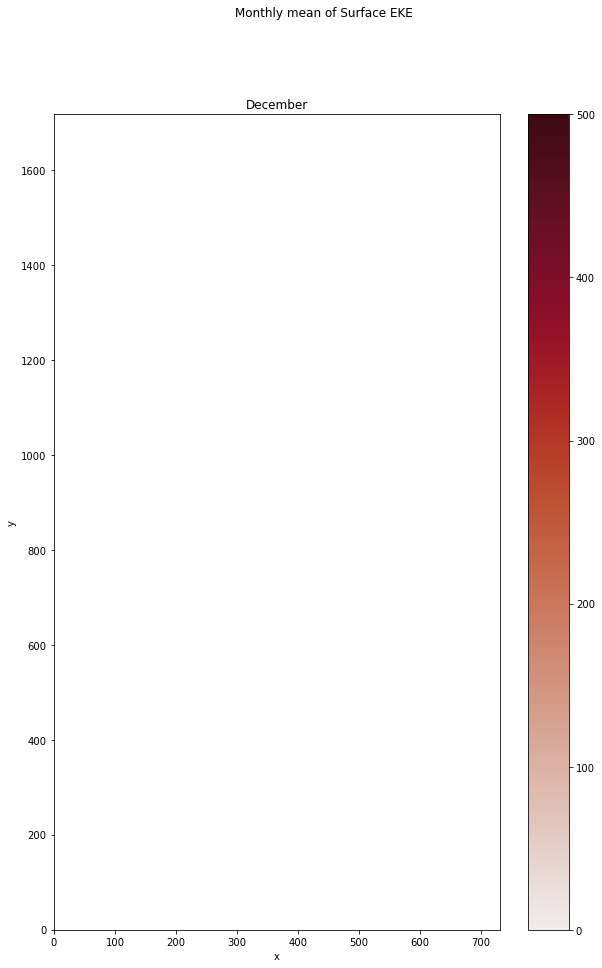

In [20]:
plot_one_month(10000*eke[0],mask[0],0,500,'cmo.amp','Surface EKE','eke_surf',12)

distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

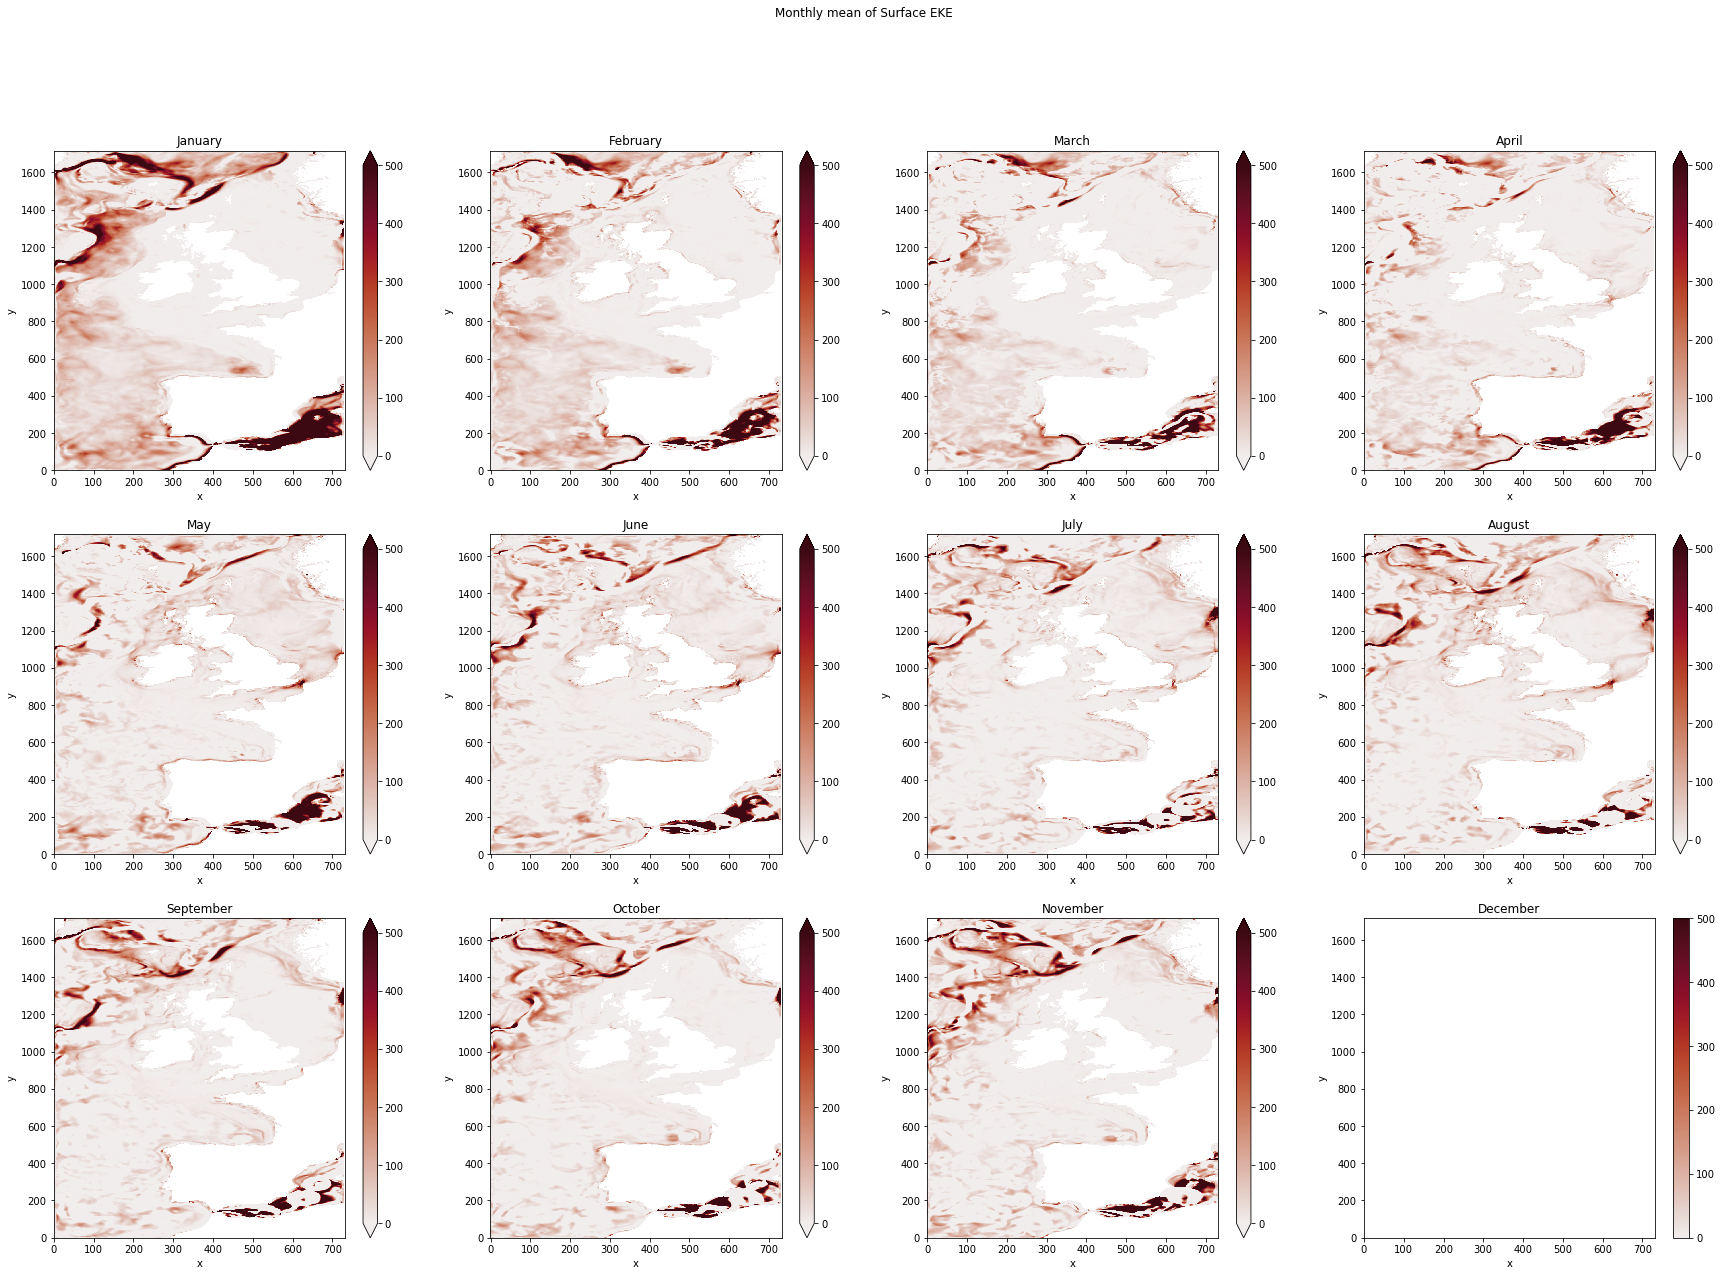

distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


In [21]:
plot_monthly(10000*eke[0],mask[0],0,500,'cmo.amp','Surface EKE','eke_surf')